**Explorar BD**



* 2.240 registros
* verificar os tipos de dados de cada coluna
* verificar os registros distintos de cada coluna qualitativa
* tratar possíveis dados ausentes, nulos, divergência de tipo de dado com valor necessário

In [72]:
# Importando bibliotecas
import pandas as pd
import seaborn as sns
from google.colab import data_table
from vega_datasets import data
from matplotlib import pyplot as plt
import seaborn as sns

# Bibliotecas para modelo
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer


In [22]:
# buscar o arquivo
bd = pd.read_csv('/content/drive/MyDrive/ml_project1_data.csv')

# Usando biblioteca do google colab para melhor visualizar os 10 primeiros registros e sua formatação
data_table.DataTable(bd, include_index=False, num_rows_per_page=10)


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Z_CostContact,Z_Revenue,Response
0,5524,1957,Graduation,Single,58138.0,0,0,2012-09-04,58,635,...,7,0,0,0,0,0,0,3,11,1
1,2174,1954,Graduation,Single,46344.0,1,1,2014-03-08,38,11,...,5,0,0,0,0,0,0,3,11,0
2,4141,1965,Graduation,Together,71613.0,0,0,2013-08-21,26,426,...,4,0,0,0,0,0,0,3,11,0
3,6182,1984,Graduation,Together,26646.0,1,0,2014-02-10,26,11,...,6,0,0,0,0,0,0,3,11,0
4,5324,1981,PhD,Married,58293.0,1,0,2014-01-19,94,173,...,5,0,0,0,0,0,0,3,11,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10870,1967,Graduation,Married,61223.0,0,1,2013-06-13,46,709,...,5,0,0,0,0,0,0,3,11,0
2236,4001,1946,PhD,Together,64014.0,2,1,2014-06-10,56,406,...,7,0,0,0,1,0,0,3,11,0
2237,7270,1981,Graduation,Divorced,56981.0,0,0,2014-01-25,91,908,...,6,0,1,0,0,0,0,3,11,0
2238,8235,1956,Master,Together,69245.0,0,1,2014-01-24,8,428,...,3,0,0,0,0,0,0,3,11,0


In [23]:
# Nome de todas as colunas e qtd de linhas e colunas, e tipos de dados
qtd_linhas = bd.shape[0]
qtd_colunas = bd.shape[1]
tipos_dados = bd.dtypes

# Verificar se alguma coluna tem valores Nan
valores_nan = bd.isna().any()
colunas_nan = []
for coluna in valores_nan.index:
  if valores_nan[coluna]:
    colunas_nan.append(coluna)

print(qtd_colunas)
print(qtd_linhas)
print(colunas_nan)
print(tipos_dados)

29
2240
['Income']
ID                       int64
Year_Birth               int64
Education               object
Marital_Status          object
Income                 float64
Kidhome                  int64
Teenhome                 int64
Dt_Customer             object
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Z_CostContact            int64
Z_Revenue                int64
Response                 int64
dtype: object


In [24]:
# Transformar a coluna Dt_Customer em data
bd['Dt_Customer'] = pd.to_datetime(bd['Dt_Customer'], errors='coerce')

# Validar que deu certo
print(bd.Dt_Customer.dtypes)

datetime64[ns]


In [25]:
# Sustituindo os valores Nan da coluna Income conforme mediana agrupada por 'Year_Birth', 'Education' e 'Marital_Status'

mediana_income = bd.groupby(['Year_Birth', 'Education', 'Marital_Status'])['Income'].transform(lambda x: x.median().round(0))

# Substituindo NaN em 'Income' pelas medianas
bd['Income'].fillna(mediana_income, inplace=True)

# Verificando se ainda existe Nan e colocando a mediana
if bd['Income'].isna().any():
    bd['Income'].fillna(bd['Income'].median().round(0), inplace=True)

# Transformar a coluna Income do tipo decimal para inteiro
bd['Income'] = bd['Income'].astype('int')

print(bd['Income'])

/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


0       58138
1       46344
2       71613
3       26646
4       58293
        ...  
2235    61223
2236    64014
2237    56981
2238    69245
2239    52869
Name: Income, Length: 2240, dtype: int64


/usr/local/lib/python3.10/dist-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)


In [26]:
# Verificar registros distintintos nas colunas de texto
colunas_string = bd.select_dtypes(include=['object']).columns
valores_unicos =  {coluna: bd[coluna].unique() for coluna in colunas_string}

for coluna, valores in valores_unicos.items():
    print(f"Valores únicos na coluna {coluna}: {valores}")

Valores únicos na coluna Education: ['Graduation' 'PhD' 'Master' 'Basic' '2n Cycle']
Valores únicos na coluna Marital_Status: ['Single' 'Together' 'Married' 'Divorced' 'Widow' 'Alone' 'Absurd' 'YOLO']


In [27]:
# Juntar os valores da Marital_Status que indiquem solteiros (single, divorced, alone e Widow) e casados_uniaoestavel (together e married) e outros (absurd, yolo)

def mapear_status(marital_status):
    if marital_status in ['Single', 'Divorced', 'Alone', 'Widow']:
        return 'solteiro'
    elif marital_status in ['Together', 'Married']:
        return 'casado_uniao'
    elif marital_status in ['Absurd', 'YOLO']:
        return 'outros'
    else:
        return marital_status

# Aplicando a junção dos status
bd['Marital_Status'] = bd['Marital_Status'].apply(mapear_status)

# Validando se deu certo
print(bd['Marital_Status'].unique())


['solteiro' 'casado_uniao' 'outros']


# **Todas as ideias possíveis**



*   Associar grupos de análise por estado civil e renda, agrupar
*   Analisar reclamações
*   Analisar resposta de aceite de campanhas
*   Analisar receitas/despesas/custos de contato
*   Definir personas/perfis de compra

#### Avaliando novamente com base no objetivo proposto - Clientes propensos a comprar oferta

*   Perfil que de fato comprou as ofertas, agrupar com base no dados sócio-demográficos (idade, estado civil, renda, educação...) e dados de preferência de compras nos ultimos 3 anos.
*   Após determinar o perfil dos clientes que aceitaram/adereriram a alguma das campanhas, rodar um modelo de regressão logística para marcar os demais clientes como propensos sim/não a aceitar/aderir a alguma campanha








In [28]:
# Total de respondentes
tt = len(bd)

# Respondeu sim
qtd_response_1 = (bd['Response'] == 1).sum()

# Diferença valor
dif_real = tt - qtd_response_1

# % de respondentes
perct = ((qtd_response_1 / tt) *100).round(2)

# Qtd que respondeu sim e aceitou alguma das campanhas
accepted_cols = [col for col in bd if col.startswith('AcceptedCmp')]
bd['acceptedCmp'] = bd[accepted_cols].sum(axis=1)

# Converter a soma da nova coluna AcceptedCmp para 1 se maior que 0, e para 0 se for 0
bd['acceptedCmp'] = (bd['acceptedCmp'] > 0).astype('int')

# Qtd que aceitou alguma das campanhas
aceite = (bd['acceptedCmp'] == 1).sum()

# Qtd da Response=1 e acceptedCmp=1
respon_accep = ((bd['Response'] == 1) & (bd['acceptedCmp'] == 1)).sum()

# Qtd da response=0 e acceptedCmp=1
respon0_accep1 = ((bd['Response'] == 0) & (bd['acceptedCmp'] == 1)).sum()

print("Total de respondentes: ", tt)
print("Respondeu sim: ", qtd_response_1)
print("Diferença valor: ", dif_real)
print("% de respondentes :", perct)
print(bd['acceptedCmp'].unique())
print("Qtd que aceitou alguma das campanhas: ", aceite)
print("Qtd da Response=1 e acceptedCmp=1: ", respon_accep)
print("Qtd da response=0 e acceptedCmp=1: ", respon0_accep1)

Total de respondentes:  2240
Respondeu sim:  334
Diferença valor:  1906
% de respondentes : 14.91
[0 1]
Qtd que aceitou alguma das campanhas:  463
Qtd da Response=1 e acceptedCmp=1:  188
Qtd da response=0 e acceptedCmp=1:  275


In [29]:
# Filtrar os clientes que responderam 1 para 'acceptedCmp3'
df_accepted_customers = bd[bd['acceptedCmp'] == 1]

# Análise do perfil dos clientes e transpondo os dados pra melhor visualizar
profile = df_accepted_customers.describe(include='all')
profile.T

<ipython-input-29-7a4c04f840a3>:5: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  profile = df_accepted_customers.describe(include='all')


,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ID,463.0,NaN,NaN,NaN,NaT,NaT,5326.691145,3144.944737,1.0,2622.0,5186.0,7893.5,11101.0
Year_Birth,463.0,NaN,NaN,NaN,NaT,NaT,1968.079914,12.980008,1899.0,1957.5,1969.0,1978.0,1996.0
Education,463,5,Graduation,230,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,463,3,casado_uniao,298,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,463.0,NaN,NaN,NaN,NaT,NaT,65051.62851,20335.832434,5648.0,50851.0,69372.0,80951.0,105471.0
Kidhome,463.0,NaN,NaN,NaN,NaT,NaT,0.228942,0.435771,0.0,0.0,0.0,0.0,2.0
Teenhome,463.0,NaN,NaN,NaN,NaT,NaT,0.399568,0.536705,0.0,0.0,0.0,1.0,2.0
Dt_Customer,463,318,2012-11-10 00:00:00,5,2012-08-01,2014-06-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Recency,463.0,NaN,NaN,NaN,NaT,NaT,48.222462,28.882584,0.0,24.0,48.0,72.0,99.0
MntWines,463.0,NaN,NaN,NaN,NaT,NaT,611.282937,400.254513,0.0,292.0,600.0,942.0,1493.0


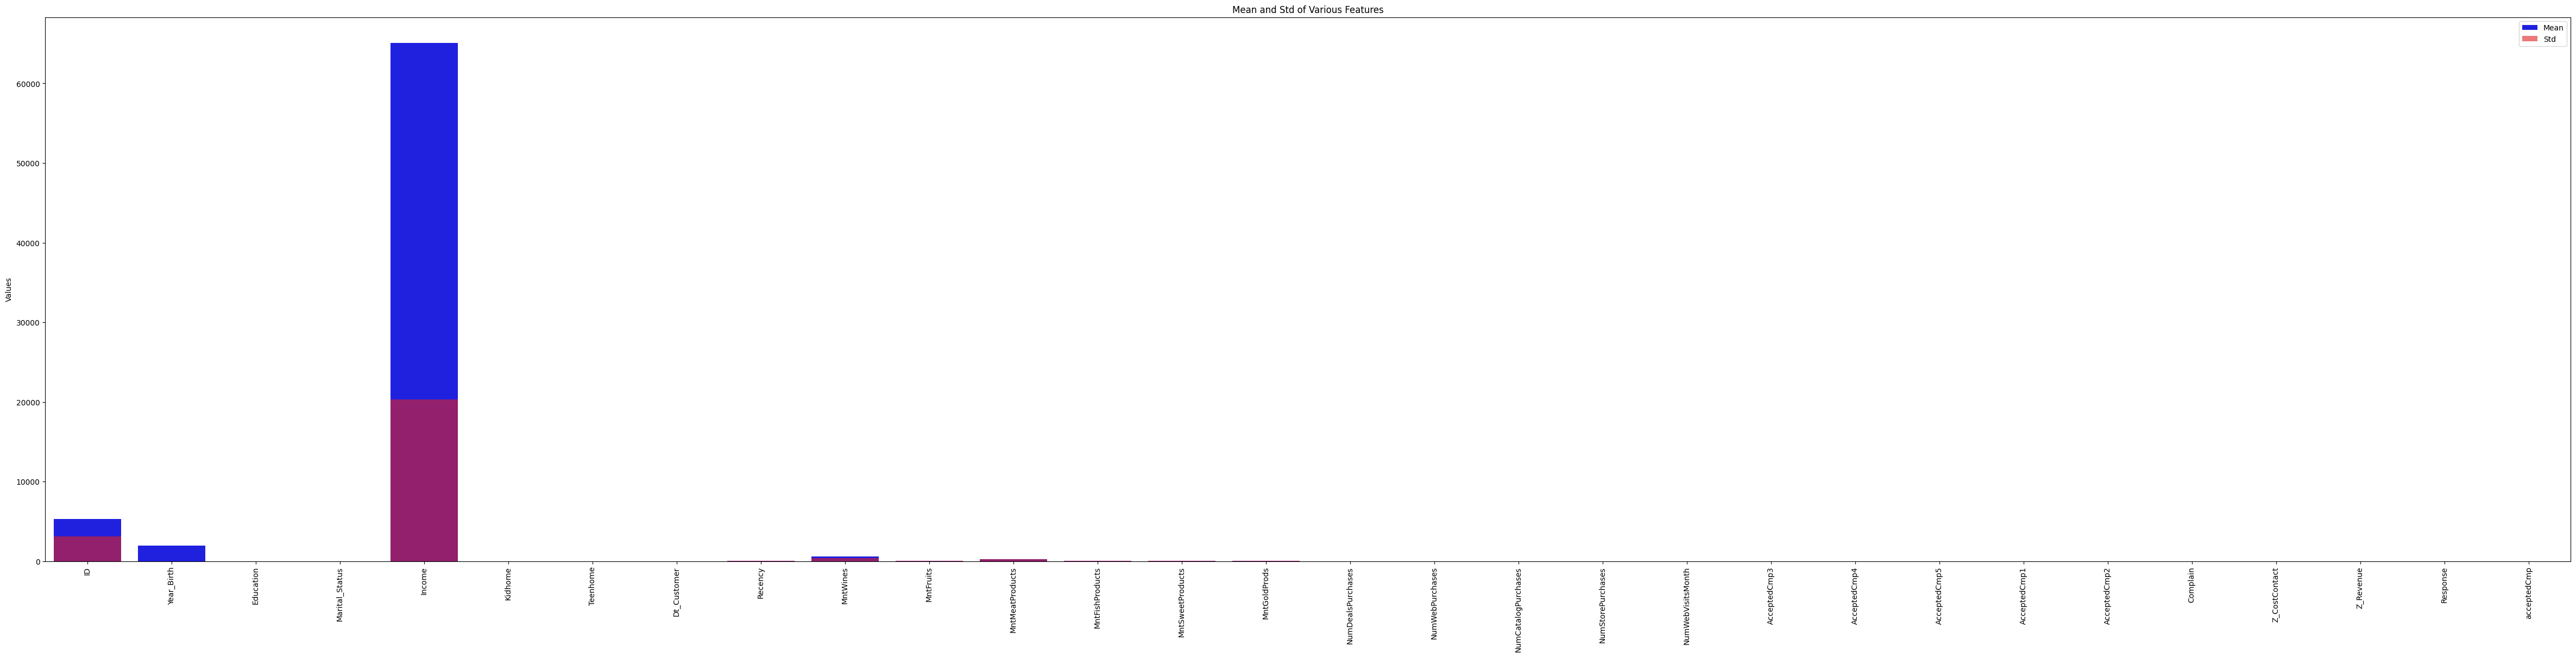

In [30]:
# Visualizações para entender e determinar qual o perfil
df = pd.DataFrame(profile, index=['mean', 'std'])

df = df.T

plt.figure(figsize=(60, 13))
sns.barplot(x=df.index, y='mean', data=df, color='blue', label='Mean')
sns.barplot(x=df.index, y='std', data=df, color='red', alpha=0.6, label='Std')

plt.xticks(rotation=90)
plt.ylabel('Values')
plt.title('Mean and Std of Various Features')
plt.legend()
plt.show()

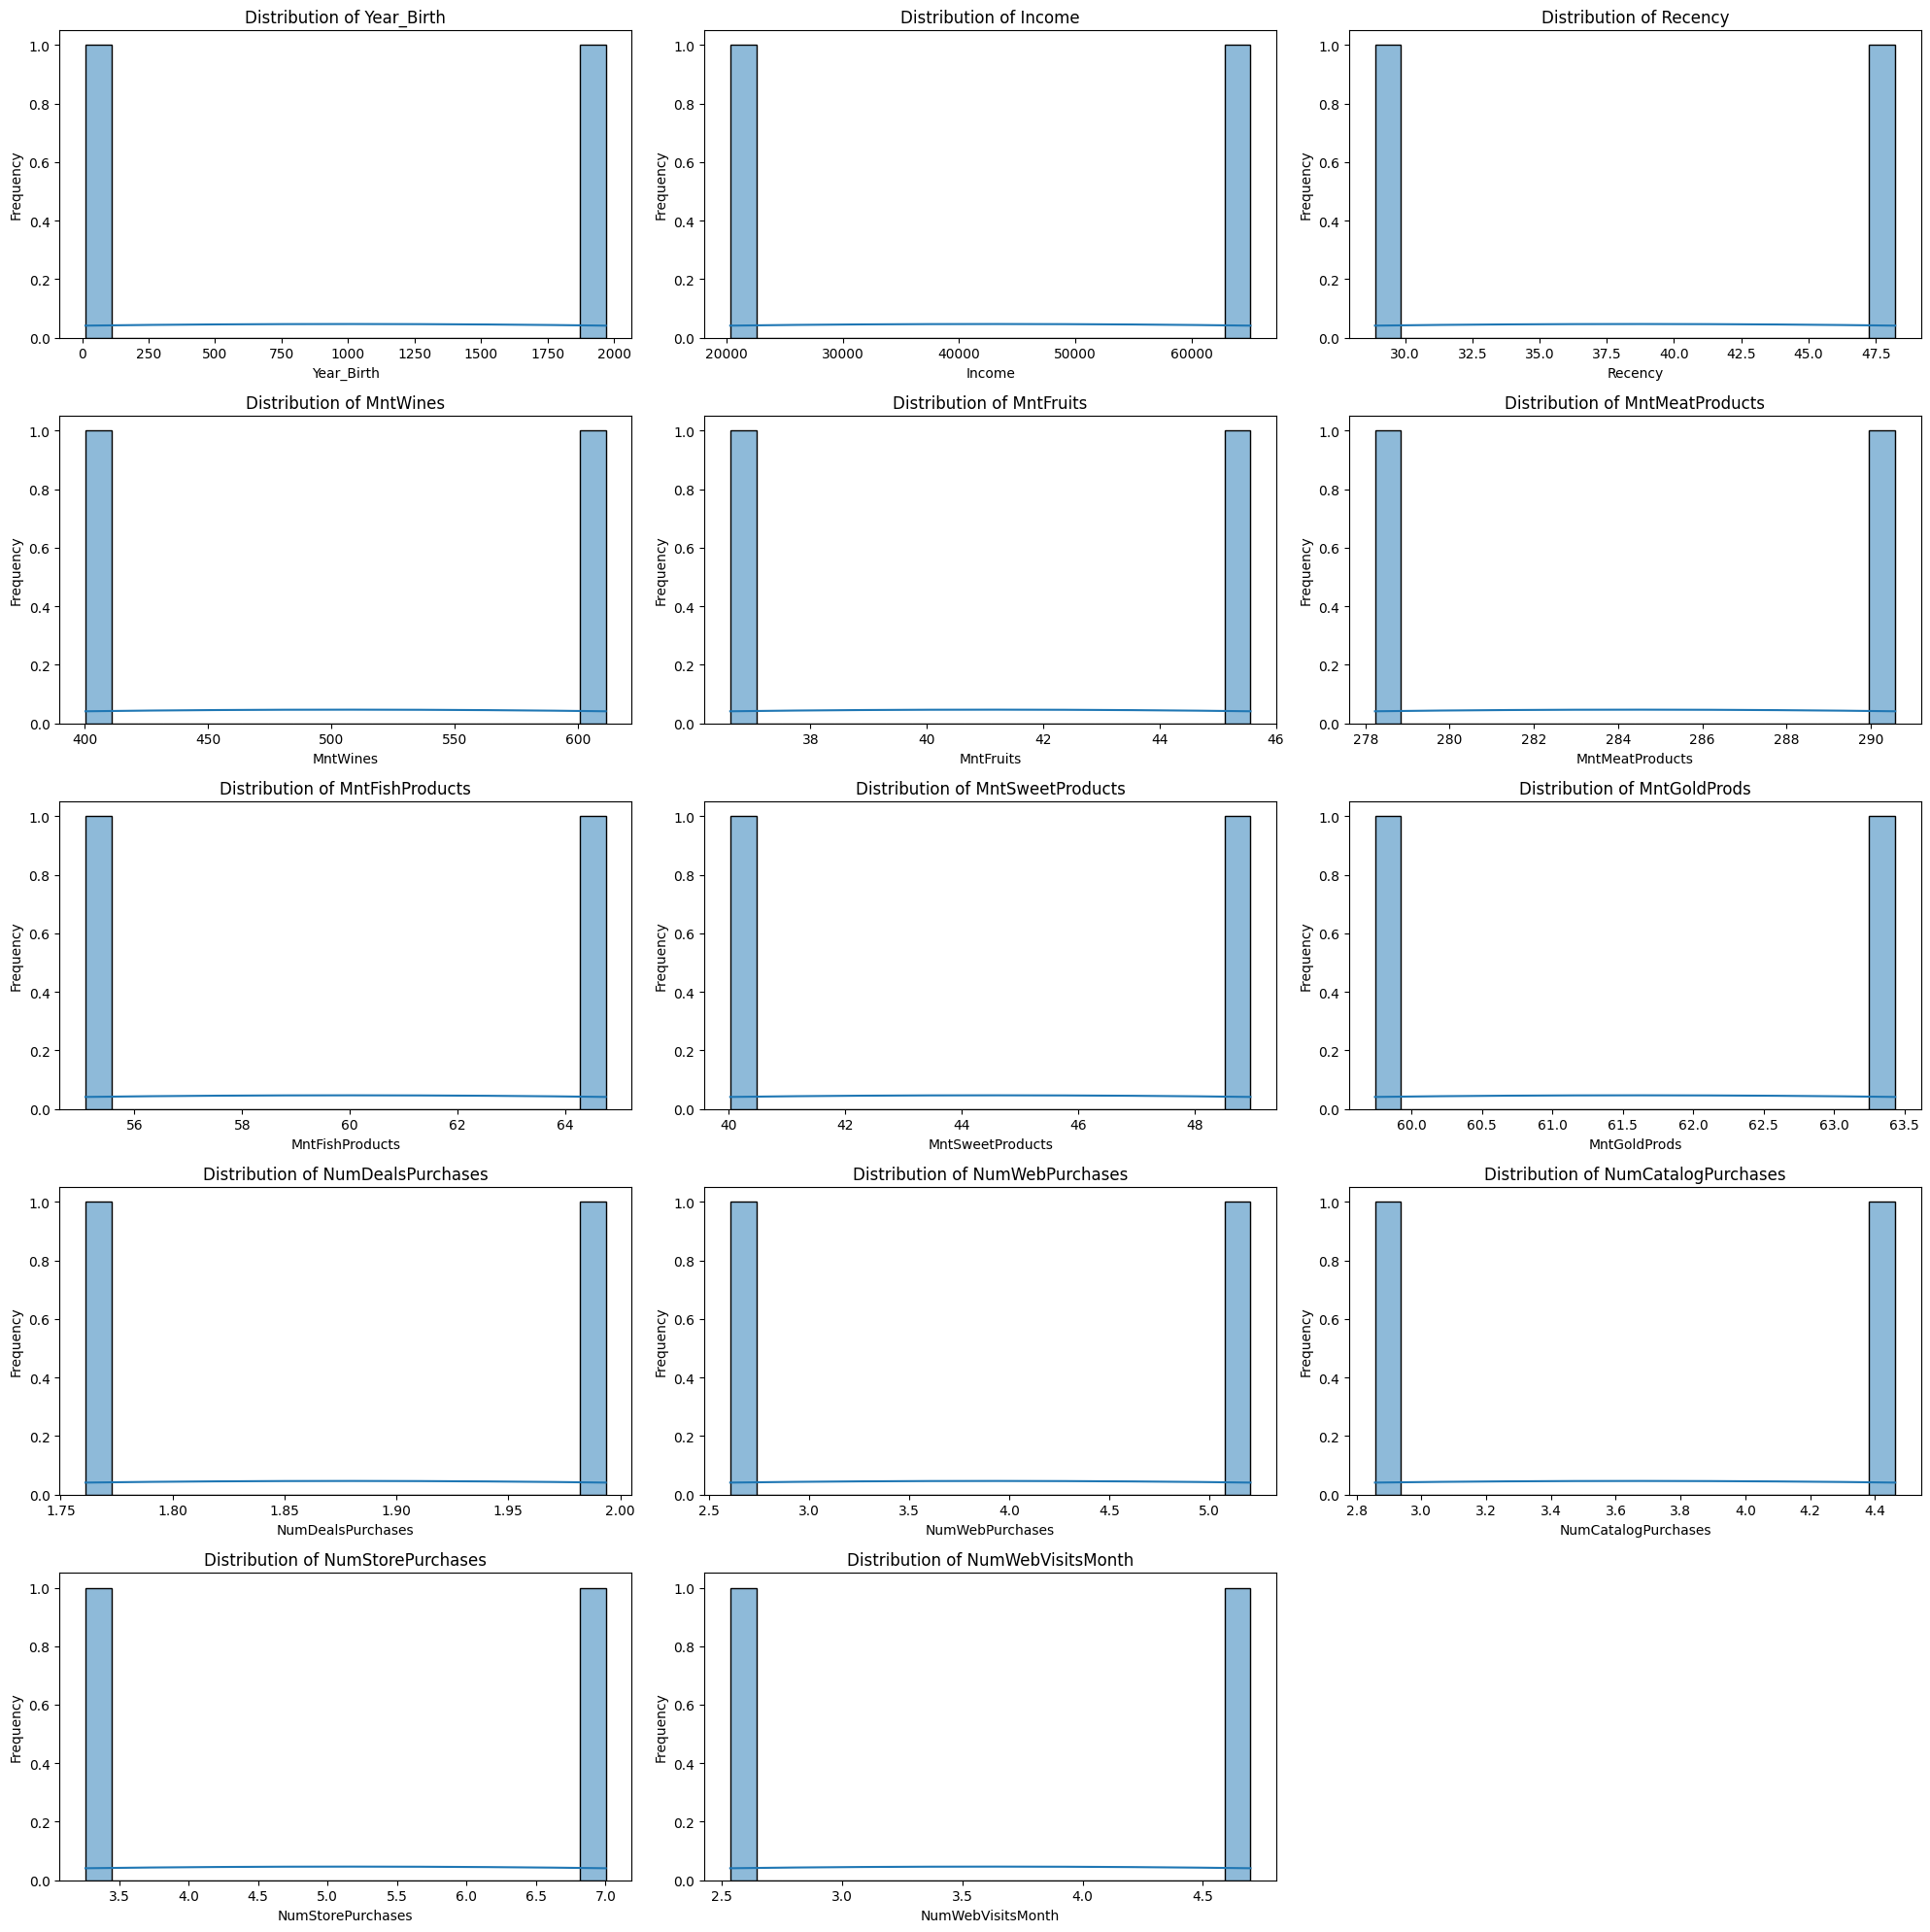

In [31]:
# Variáveis para análise de distribuição individual númericas
individual_vars = ['Year_Birth', 'Income', 'Recency', 'MntWines', 'MntFruits',
                   'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
                   'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
                   'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

# Criando gráficos de distribuição
plt.figure(figsize=(20, 20))

for i, var in enumerate(individual_vars, 1):
    plt.subplot(5, 3, i)
    sns.histplot(df.loc[var, :], kde=True, bins=20)
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [53]:
# Filtrando as linhas onde acceptedCmp é 0
df_accepted_customers0 = bd[bd['acceptedCmp'] == 0].copy()

# Juntar com a base de clientes que não aderiu a nenhuma campanha
df_combined = pd.concat([df_accepted_customers0, df_accepted_customers])



Modelo de Regressão Logística para determinar clientes propensos

---

Após a normalização das variáveis que estavam com muita discrepância, rodar o modelo de regressão logísitca para determinar os propensos.

In [59]:

# Selecionando as variáveis
variaveis = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'MntWines', 'MntMeatProducts',
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                    'NumWebVisitsMonth', 'acceptedCmp']

dados_relevantes = df_combined[variaveis]

# Tratar valores faltantes se ainda houver
num_faltantes = ['Year_Birth', 'Income', 'MntWines', 'MntMeatProducts', 'NumDealsPurchases',
                'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth']

num_transf = SimpleImputer(strategy='mean')

# Codificando variáveis categóricas em númericas com odificação one-hot
cat_features = ['Education', 'Marital_Status']
cat_transf = OneHotEncoder()

# Combinando as variáveis numéricas e categóricas
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transf, num_faltantes),
        ('cat', cat_transf, cat_features)
    ])

# Separando as características (X) e o alvo (y)
X = dados_relevantes.drop('acceptedCmp', axis=1)
y = dados_relevantes['acceptedCmp']

# Dividindo a base em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

# Criando um pipeline para aplicar o pré-processamento e a normalização
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', StandardScaler())
])

X_train_transformed = pipeline.fit_transform(X_train)
X_test_transformed = pipeline.transform(X_test)

X_train_transformed.shape, X_test_transformed.shape


((1568, 17), (672, 17))

In [60]:
# Criando e treinando o modelo de regressão logística
logistic_model = LogisticRegression(max_iter=1000, random_state=0)
logistic_model.fit(X_train_transformed, y_train)

# Previsões no conjunto de teste
y_pred = logistic_model.predict(X_test_transformed)

# Avaliando os resultados do modelo
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

accuracy, report

(0.8541666666666666,
 '              precision    recall  f1-score   support\n\n           0       0.87      0.97      0.92       544\n           1       0.74      0.36      0.48       128\n\n    accuracy                           0.85       672\n   macro avg       0.80      0.66      0.70       672\nweighted avg       0.84      0.85      0.83       672\n')

Filtrar os clientes que não aderiram a nenhuma campanha e adicionando a coluna para identificar se é propenso a uma próxima campanha.

Os clientes que já aderiram a alguma das 5 campanhas, automaticamente são classificados como propensos.

In [76]:
# Filtrando os clientes com 'acceptedCmp=0' para identificar os que possuem alguma propensão
dados_relevantes = ['Year_Birth', 'Education', 'Marital_Status', 'Income', 'MntWines', 'MntMeatProducts',
                    'NumDealsPurchases', 'NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases',
                    'NumWebVisitsMonth']

clientes_nao_aceitaram = df_combined[df_combined['acceptedCmp'] == 0][dados_relevantes]

# Transformando os dados para o formato adequado
clientes_nao_aceitaram_transformed = pipeline.transform(clientes_nao_aceitaram)

# Realizando previsões de propensão
propensao_prevista = logistic_model.predict(clientes_nao_aceitaram_transformed)

# Adicionando as previsões ao conjunto de dados original
clientes_nao_aceitaram['Propensity'] = propensao_prevista
clientes_nao_aceitaram['Propensity'] = clientes_nao_aceitaram['Propensity']

# Exibindo as primeiras linhas do resultado
clientes_nao_aceitaram.head()

,Year_Birth,Education,Marital_Status,Income,MntWines,MntMeatProducts,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Propensity
0,1957,Graduation,solteiro,58138,635,546,3,8,10,4,7,1
1,1954,Graduation,solteiro,46344,11,6,2,1,1,2,5,0
2,1965,Graduation,casado_uniao,71613,426,127,1,8,2,10,4,0
3,1984,Graduation,casado_uniao,26646,11,20,2,2,0,4,6,0
4,1981,PhD,casado_uniao,58293,173,118,5,5,3,6,5,0


In [80]:
# Base de clientes propensos
clientes_ja_aceitaram = df_combined[df_combined['acceptedCmp'] == 1][dados_relevantes]
clientes_ja_aceitaram['Propensity'] = 1

# Juntando as bases
bd_propensos = pd.concat([clientes_nao_aceitaram, clientes_ja_aceitaram])

# Qtd propensos
qtd_propensity_1 = bd_propensos['Propensity'].sum()

qtd_propensity_1

544

In [82]:
# Visualizando a base de propensos
bd_propensos.head()

,Year_Birth,Education,Marital_Status,Income,MntWines,MntMeatProducts,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Propensity
0,1957,Graduation,solteiro,58138,635,546,3,8,10,4,7,1
1,1954,Graduation,solteiro,46344,11,6,2,1,1,2,5,0
2,1965,Graduation,casado_uniao,71613,426,127,1,8,2,10,4,0
3,1984,Graduation,casado_uniao,26646,11,20,2,2,0,4,6,0
4,1981,PhD,casado_uniao,58293,173,118,5,5,3,6,5,0


OBS: Parti do príncipio: mais importante que o aceite de aderir/aceitar a alguma campanha, é o indicativo de que de fato o fez.
E então separar a base dos clientes que aderiram a alguma campanha, determinar seu perfil, e então rodar um modelo para ver quais dos demais clientes teriam propensão a aderir a alguma campanha sim/não.